In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [18]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [19]:
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup, MAPParameterGroup, ParameterWithPrior
from torch.nn import Parameter

In [20]:
class ExactGPObservationModel(gpytorch.ObservationModel):
    def __init__(self):
        super(ExactGPObservationModel,self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        
        noise_prior_mean = Variable(torch.Tensor([0]))
        noise_prior_var = Variable(torch.Tensor([2]).unsqueeze(0))
        lengthscale_prior_mean = Variable(torch.Tensor([-1.8]))
        lengthscale_prior_var = Variable(torch.Tensor([0.01]).unsqueeze(0))
        self.params = MAPParameterGroup(
            log_noise=ParameterWithPrior(
                          Parameter(torch.Tensor([-2])),
                          GaussianRandomVariable(noise_prior_mean,noise_prior_var)
            ),
            log_lengthscale=ParameterWithPrior(
                          Parameter(torch.Tensor([0])),
                          GaussianRandomVariable(lengthscale_prior_mean,lengthscale_prior_var)
            ),
        )
    
    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x, log_lengthscale=self.params.log_lengthscale)
        
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred, self.params.log_noise

prior_observation_model = ExactGPObservationModel()

In [21]:
def plot_model_and_predictions(observation_model):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = observation_model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

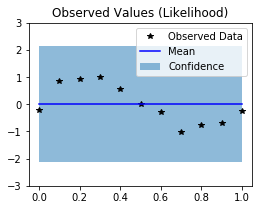

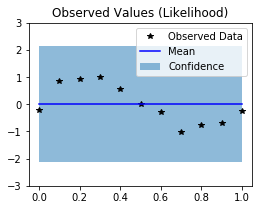

In [22]:
plot_model_and_predictions(prior_observation_model)

In [23]:
from gpytorch.inference import Inference

def log_function(loss, optimizer, observation_model):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = Inference(prior_observation_model)
posterior_observation_model = infer.run(train_x, train_y)

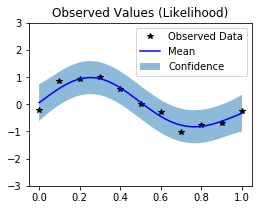

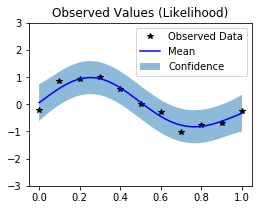

In [24]:
plot_model_and_predictions(posterior_observation_model)